# Промышленность

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургического комбината «Стальная птица» требуется уменьшить потребление электроэнергии на этапе обработки стали. Для этого требуется контролировать температуру сплава.

Задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса.

### Описание процесса обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.

Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.

Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.

Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

In [872]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from pathlib import Path
from sqlalchemy import create_engine, text

In [873]:
# Определим переменные
RANDOM_STATE = 190923
# папка для хранения временных данных
TMP='./cache'
# Использование данных из кэша
USE_CACHE=False

In [874]:
# создаём временный каталог для хранения данных
Path(TMP).mkdir(parents=True, exist_ok=True)

In [875]:
# проверка кэша
onlyfiles = [f for f in listdir(TMP) if isfile(join(TMP, f))]

onlyfiles

['steel.data_arc.csv',
 'steel.data_bulk.csv',
 'steel.data_bulk_time.csv',
 'steel.data_gas.csv',
 'steel.data_temp.csv',
 'steel.data_wire.csv',
 'steel.data_wire_time.csv']

In [876]:
USE_CACHE = len(onlyfiles) > 0

## Подключение к базе данных

In [877]:
db_config = {
    'user': 'praktikum_student',# имя пользователя
    'pwd': 'Sdf4$2;d-d30pp',# пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,# порт подключения
    'db': 'data-science-final'# название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string)
conn = engine.connect()

In [878]:
query = text('''
SELECT * FROM information_schema.tables AS t
WHERE t.table_schema = 'steel';
''')

tables_df = pd.read_sql_query(query, conn)

tables_df

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,data-science-final,steel,data_arc,BASE TABLE,None,None,None,None,None,YES,NO,None
1,data-science-final,steel,data_bulk,BASE TABLE,None,None,None,None,None,YES,NO,None
2,data-science-final,steel,data_bulk_time,BASE TABLE,None,None,None,None,None,YES,NO,None
3,data-science-final,steel,data_gas,BASE TABLE,None,None,None,None,None,YES,NO,None
4,data-science-final,steel,data_temp,BASE TABLE,None,None,None,None,None,YES,NO,None
5,data-science-final,steel,data_wire,BASE TABLE,None,None,None,None,None,YES,NO,None
6,data-science-final,steel,data_wire_time,BASE TABLE,None,None,None,None,None,YES,NO,None


### Описание данных

База данных состоит из нескольких таблиц:
* steel.data_arc — данные об электродах;
* steel.data_bulk — данные об объёме сыпучих материалов;
* steel.data_bulk_time — данные о времени подачи сыпучих материалов;
* steel.data_gas — данные о продувке сплава газом;
* steel.data_temp — данные об измерениях температуры;
* steel.data_wire — данные об объёме проволочных материалов;
* steel.data_wire_time — данные о времени подачи проволочных материалов.

__Таблица steel.data_arc__
* key — номер партии;
* BeginHeat — время начала нагрева;
* EndHeat — время окончания нагрева;
* ActivePower — значение активной мощности;
* ReactivePower — значение реактивной мощности.

__Таблица steel.data_bulk__
* key — номер партии;
* Bulk1 … Bulk15 — объём подаваемого материала.

__Таблица steel.data_bulk_time__
* key — номер партии;
* Bulk1 … Bulk15 — время подачи материала.

__Таблица steel.data_gas__
* key — номер партии;
* gas — объём подаваемого газа.

__Таблица steel.data_temp__
* key — номер партии;
* MesaureTime — время замера;
* Temperature — значение температуры.

__Таблица steel.data_wire__
* key — номер партии;
* Wire1 … Wire15 — объём подаваемых проволочных материалов.

__Таблица steel.data_wire_time__
* key — номер партии;
* Wire1 … Wire15 — время подачи проволочных материалов.

Во всех таблицах столбец `key` содержит номер партии. В таблицах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### Первичное исследование таблиц

Чтобы не загружать базу данных запросами, сохраним информацию в "локальном кэше"

In [879]:
# создадим вспомогательные функции

def query_fast(query):
    """
    Быстрое выполнение запроса
    
    Параметры:
    ----------
    query: text - запрос
    """
    return pd.read_sql_query(text(query), conn)

def query_info(query, limit=5):
    """
    Получение простой информации по запросу
    
    Параметры:
    ----------
    query: text - запрос
    where: text - условие
    limit: integer - количество записей для вывода
    """
    table_query = text(f'{query} LIMIT {limit};')
    table_df = pd.read_sql_query(table_query, conn)
    display(table_df)
    
    table_count_query = text(f'{query.replace("*", "COUNT(*)")};')
    table_count_df = pd.read_sql_query(table_count_query, conn)
    print(f"Общее количество записей: {table_count_df.loc[0, 'count']}")

In [880]:
# проверим все талбицы на наличие данных и сохраним результаты в локальное хранилище
tables = [
    'steel.data_arc', 
    'steel.data_bulk', 
    'steel.data_bulk_time', 
    'steel.data_gas', 
    'steel.data_temp', 
    'steel.data_wire', 
    'steel.data_wire_time'
]

if not USE_CACHE:
    for table in tables:
        query_info(f'SELECT * FROM {table}')
    
    # Так как количество данных в таблицах не столь велико, то сохраним данные в кэше
    for table in tables:
        query_fast(f'SELECT * FROM {table}').to_csv(TMP + f'/{table}.csv', index=False)
    
    USE_CACHE = True
else:
    print('Данные будут получены из локального кэша')

Данные будут получены из локального кэша


In [881]:
# закрываем соединение
engine.dispose()

#### Данные об электродах

In [882]:
data_arc = pd.read_csv(TMP + '/steel.data_arc.csv')

data_arc['BeginHeat'] = pd.to_datetime(data_arc['BeginHeat'], format='%H:%M:%S').dt.time
data_arc['EndHeat'] = pd.to_datetime(data_arc['EndHeat'], format='%H:%M:%S').dt.time

display(data_arc.head())

print()

data_arc.info()

print()

data_arc.describe()

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB



,key,ActivePower,ReactivePower
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


___Примечание___: после анализа колонок `ReactivePower` выявлено аномальное минимальное значение, изучим подробнее.

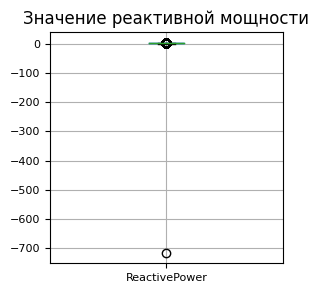

In [883]:
data_arc.boxplot(column=['ReactivePower'], figsize=(3, 3), fontsize=8)
plt.title('Значение реактивной мощности')
plt.show()

In [884]:
condition = data_arc['ReactivePower'] < -600
data_arc[condition]

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
9781,2116,00:44:48,00:46:37,0.495782,-715.504924


In [885]:
# заменим аномальный всплеск средним значением
data_arc.loc[condition, 'ReactivePower'] = data_arc['ReactivePower'].mean()

Сгененрируем фичи

In [886]:
def total_seconds(x):
    """
    Вспомогательная функция для подсчёта секунд
    
    Параметры:
    ----------
    x: datetime.time
    
    Результат:
    ----------
    int - общее количество секунд
    """

    return (x.hour * 3600) + (x.minute * 60) + x.second

def diff_seconds(row):
    """
    Вспомогательная функция для подсчёта разницы в секундах
    
    Параметры:
    ----------
    row: Serias
    
    Результат:
    int - секунды
    """
    if row['EndHeatSeconds'] > row['BeginHeatSeconds']:
        return row['EndHeatSeconds'] - row['BeginHeatSeconds']
    else:
        # таким образом обработаем переход через 0
        return (row['EndHeatSeconds'] + 86400) - row['BeginHeatSeconds']

In [887]:
# переведём временные значения в секунды
data_arc['BeginHeatSeconds'] = data_arc['BeginHeat'].apply(total_seconds)
data_arc['EndHeatSeconds'] = data_arc['EndHeat'].apply(total_seconds)

# генерация новых признаков
data_arc['DeltaHeatSeconds'] = data_arc.apply(diff_seconds, axis=1)

data_arc['TotalPower'] = data_arc['ActivePower'] + data_arc['ReactivePower']
data_arc['RelPower'] = data_arc['ActivePower'] / data_arc['ReactivePower']

In [888]:
# проверим ещё раз распределение
data_arc[['BeginHeatSeconds', 'EndHeatSeconds', 'DeltaHeatSeconds']].describe()

,BeginHeatSeconds,EndHeatSeconds,DeltaHeatSeconds
count,14876.000000,14876.000000,14876.000000
mean,43148.600027,43192.494689,171.670946
std,24998.711157,24996.782760,98.186803
min,1.000000,7.000000,11.000000
25%,21776.750000,21793.750000,107.000000
50%,42775.000000,42832.000000,147.000000
75%,64685.750000,64730.250000,214.000000
max,86375.000000,86398.000000,907.000000


In [889]:
# сагрегируем признаки по номеру партии
data_arc = data_arc.groupby('key').agg({'ActivePower': 'sum', 'ReactivePower': 'sum', 'BeginHeatSeconds': 'min', 'EndHeatSeconds': 'max', 'DeltaHeatSeconds': 'sum', 'TotalPower': 'sum', 'RelPower': 'sum', 'BeginHeat': 'count'})

In [890]:
data_arc = data_arc.rename(columns= {'BeginHeat':'Iteration'})
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ActivePower       3214 non-null   float64
 1   ReactivePower     3214 non-null   float64
 2   BeginHeatSeconds  3214 non-null   int64  
 3   EndHeatSeconds    3214 non-null   int64  
 4   DeltaHeatSeconds  3214 non-null   int64  
 5   TotalPower        3214 non-null   float64
 6   RelPower          3214 non-null   float64
 7   Iteration         3214 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 226.0 KB


В итоге мы получаем следующую таблицу:
* `key` - номер партии;
* `ActivePower` - значение активной мощности;
* `BeginHeatSeconds` - время начала нагрева в секундах;
* `EndHeatSeconds` - время завершения нагрева в секундах;
* `ReactivePower` - значение реактивной мощности;
* `DeltaHeatSeconds` - время нагрува в секундах;
* `TotalPower` - сумма мощностей;
* `RelPower` - соотношение активной мощности к реактивной;
* `Iteration` - количество итераций.

#### Данные об объёме сыпучих материалов

In [891]:
data_bulk = pd.read_csv(TMP + '/steel.data_bulk.csv')

display(data_bulk.head())

print()

data_bulk.info()

print()

data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [892]:
# установим индекс
data_bulk = data_bulk.set_index('key')

In [893]:
# заполним пропуски
data_bulk = data_bulk.fillna(0)

#### Данные о времени подачи сыпучих материалов

In [894]:
data_bulk_time = pd.read_csv(TMP + '/steel.data_bulk_time.csv')

display(data_bulk_time.head())

print()

data_bulk_time.info()

print()

data_bulk_time.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11:03:52,NaN,11:03:52,11:03:52
1,2,NaN,NaN,NaN,11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11:40:20,NaN,11:40:20,11:40:20
2,3,NaN,NaN,NaN,12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12:09:40,NaN,12:09:40,12:09:40
3,4,NaN,NaN,NaN,12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12:41:24,NaN,12:41:24,12:41:24
4,5,NaN,NaN,NaN,13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13:12:56,NaN,13:12:56,13:12:56



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB



,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [895]:
# установим индекс
data_bulk_time = data_bulk_time.set_index('key')

In [896]:
cols = data_bulk_time.columns

# приведём переменные Bulk N к типу time
for col in cols:
    if col.find('Bulk') >= 0:
        data_bulk_time[f'{col}Time'] = pd.to_datetime(data_bulk_time[col], format='%H:%M:%S').dt.time
        data_bulk_time[f'{col}Time'] = data_bulk_time[f'{col}Time'].apply(total_seconds)

Проверим есть ли переходя через "сутки"

In [897]:
# 1. создадим две вспомогательные функции

def get_min_value(row):
    return np.min(row.values, where=~np.isnan(row.values), initial=86400)

def get_max_value(row):
    return np.max(row.values, where=~np.isnan(row.values), initial=0)

In [898]:
# 2. выбирем колонки time для обработки
colsTime = []
for col in cols:
    colsTime.append(f'{col}Time')

In [899]:
# 3. определяем максимальное и минимальное значение
data_bulk_time['MinSecond'] = data_bulk_time[colsTime].apply(get_min_value, axis=1)
data_bulk_time['MaxSecond'] = data_bulk_time[colsTime].apply(get_max_value, axis=1)

In [900]:
# 4. находим разницу
data_bulk_time['DiffSecond'] = data_bulk_time['MaxSecond'] - data_bulk_time['MinSecond']

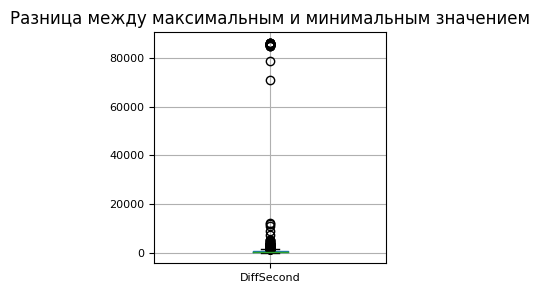

In [901]:
data_bulk_time.boxplot('DiffSecond', figsize=(3, 3), fontsize=8)
plt.title('Разница между максимальным и минимальным значением')
plt.show()

__Примечание__: на графике видны аномальные всплески в районе 70000 - это и есть переходы на другие сутки

Преобразуем данные таким образом, чтобы выводилось не время, а количество секунд, которое прошло с момента подачи материала

In [902]:
# объеденим данные с "данными об электродах"
data_bulk_time = data_bulk_time.merge(data_arc[['BeginHeatSeconds']], how='inner', left_index=True, right_index=True)
# пропуски заполним отрицательным значением
data_bulk_time = data_bulk_time.fillna(-1)

def to_second(row):
    if row[0] != -1:
        if row[0] >= row[1]:
            row[0] = row[0] - row[1]
        else:
            # тут переход на другие сутки
            row[0] = (row[0] + 86400) - row[1]
    return row[0]

# обработаем только те колонки, у которых тип time
for col in cols:
    if col.find('Bulk') >= 0:
        data_bulk_time[f'{col}Time'] = data_bulk_time[[f'{col}Time', 'BeginHeatSeconds']].apply(to_second, axis=1)

In [906]:
data_bulk_time.loc[data_bulk_time['Bulk 1Time'] > 80000, ['Bulk 1', 'Bulk 1Time', 'BeginHeatSeconds']]

,Bulk 1,Bulk 1Time,BeginHeatSeconds
key,,,
336,23:52:57,85692.0,285
880,23:36:14,84709.0,265
1471,13:40:06,86312.0,49294
1516,23:51:04,84686.0,1178
1759,23:39:32,84776.0,396
2936,23:54:24,84859.0,1205
3147,00:00:13,86333.0,80


In [820]:
# удалим временные колонки
data_bulk_time.drop(columns=cols, inplace=True)
data_bulk_time.drop(columns=['BeginHeatSeconds', 'MinSecond', 'MaxSecond', 'DiffSecond'], inplace=True)

# проверим распределение
data_bulk_time.describe()

,Bulk 1Time,Bulk 2Time,Bulk 3Time,Bulk 4Time,Bulk 5Time,Bulk 6Time,Bulk 7Time,Bulk 8Time,Bulk 9Time,Bulk 10Time,Bulk 11Time,Bulk 12Time,Bulk 13Time,Bulk 14Time,Bulk 15Time
count,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000
mean,257.285486,10.511189,829.378197,739.172634,54.296995,490.876598,10.772698,-0.490729,36.219629,85.649936,145.267903,1582.149936,56.223146,1728.529092,1392.011509
std,4038.838479,141.203133,5650.703832,5754.653140,1535.835609,4951.723941,144.483757,28.482782,1549.574481,1563.320710,2672.566251,10134.407016,1995.086690,10567.783479,9457.878207
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,87.000000,-1.000000,229.750000,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,375.000000,-1.000000,402.000000,359.000000
75%,-1.000000,-1.000000,866.000000,699.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,494.250000,-1.000000,503.000000,479.000000
max,86333.000000,2424.000000,86376.000000,86392.000000,85129.000000,86304.000000,2424.000000,1592.000000,86343.000000,86030.000000,85883.000000,86382.000000,84553.000000,86394.000000,86382.000000


__Примечание__: в результате распределения не видны максимальные значения большие, чем 86400 (количество секунд в сутках). 

In [821]:
# проверим данные
data_bulk_time.head()

,Bulk 1Time,Bulk 2Time,Bulk 3Time,Bulk 4Time,Bulk 5Time,Bulk 6Time,Bulk 7Time,Bulk 8Time,Bulk 9Time,Bulk 10Time,Bulk 11Time,Bulk 12Time,Bulk 13Time,Bulk 14Time,Bulk 15Time
key,,,,,,,,,,,,,,,
1,-1.0,-1.0,-1.0,1156.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,98.0,-1.0,98.0,98.0
2,-1.0,-1.0,-1.0,744.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,366.0,-1.0,366.0,366.0
3,-1.0,-1.0,-1.0,1452.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,166.0,-1.0,166.0,166.0
4,-1.0,-1.0,-1.0,546.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,107.0,-1.0,107.0,107.0
5,-1.0,-1.0,-1.0,457.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,103.0,-1.0,103.0,103.0


#### Данные о продувке сплава газом

In [822]:
data_gas = pd.read_csv(TMP + '/steel.data_gas.csv')

display(data_gas.head())

print()

data_gas.info()

print()

data_gas.describe()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB



,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [823]:
# установим индекс
data_gas = data_gas.set_index('key')

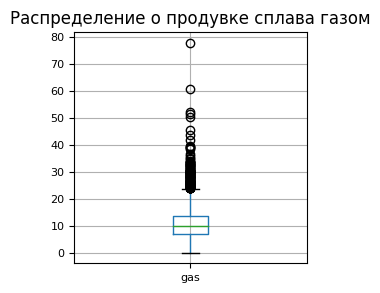

In [824]:
data_gas.boxplot('gas', figsize=(3, 3), fontsize=8)
plt.title('Распределение о продувке сплава газом')
plt.show()

In [825]:
condition = data_gas['gas'] > 60
data_gas[condition]

,gas
key,
280,60.935689
322,77.995040


Выявленные всплески заменим на средние значения 

In [826]:
data_gas.loc[condition, 'gas'] = data_gas['gas'].mean()

#### Данные об измерениях температуры

In [827]:
data_temp = pd.read_csv(TMP + '/steel.data_temp.csv')

display(data_temp.head())

print()

data_temp.info()

print()

data_temp.describe()

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB



,key,Temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [828]:
# установим индекс
data_temp = data_temp.set_index('key')

In [829]:
# обработаем поле "время замера"
data_temp['MesaureTime'] = pd.to_datetime(data_temp['MesaureTime'], format='%H:%M:%S').dt.time
data_temp['MesaureTime'] = data_temp['MesaureTime'].apply(total_seconds)

In [830]:
# объеденим данные с "данными об электродах"
data_temp = data_temp.merge(data_arc[['BeginHeatSeconds']], how='inner', left_index=True, right_on='key')

In [831]:
data_temp.head()

,MesaureTime,Temperature,BeginHeatSeconds
key,,,
1,40578,1571.0,39734
1,41153,1604.0,39734
1,41351,1618.0,39734
1,41401,1601.0,39734
1,41439,1613.0,39734


In [832]:
data_temp['MesaureSeconds'] = data_temp[['MesaureTime', 'BeginHeatSeconds']].apply(to_second, axis=1)

Проверим температуру

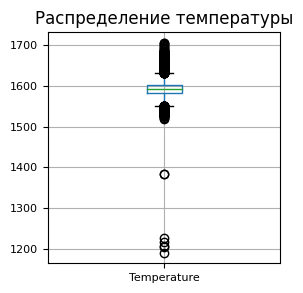

In [833]:
data_temp.boxplot('Temperature', figsize=(3, 3), fontsize=8)
plt.title('Распределение температуры')
plt.show()

In [834]:
# удалим аномально низкие значениея температуры в 1500
condition = data_temp['Temperature'] < 1500
data_temp[condition]

,MesaureTime,Temperature,BeginHeatSeconds,MesaureSeconds
key,,,,
867,51660,1191.0,51471,189
1214,19920,1208.0,19577,343
1619,39834,1218.0,39639,195
1818,1849,1383.0,80,1769
1818,1900,1383.0,80,1820
2052,53500,1227.0,53322,178
2561,27255,1204.0,26852,403


In [835]:
# заменим медианной
data_temp.loc[condition, 'Temperature'] = data_temp['Temperature'].mean()

In [836]:
# выбирем только те значения, котрые содержат как минимум два наблюдения
data_temp_filter = data_temp.groupby('key').filter(lambda x: x['Temperature'].count() > 1)

data_temp_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12265 entries, 1 to 2499
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MesaureTime       12265 non-null  int64  
 1   Temperature       12265 non-null  float64
 2   BeginHeatSeconds  12265 non-null  int64  
 3   MesaureSeconds    12265 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 479.1 KB


In [837]:
# гарантируем, что значение температуры для целевого значения должно быть последним
data_temp = data_temp_filter.sort_values(['key', 'MesaureSeconds'], ascending=True).groupby('key').agg({ 'Temperature': 'last' })
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  2475 non-null   float64
dtypes: float64(1)
memory usage: 38.7 KB


#### Данные об объёме проволочных материалов

In [855]:
data_wire = pd.read_csv(TMP + '/steel.data_wire.csv')

display(data_wire.head())

print()

data_wire.info()

print()

data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [856]:
# установим индекс
data_wire = data_wire.set_index('key')

In [857]:
# заполним пропуски
data_wire = data_wire.fillna(0)

#### Данные о времени подачи проволочных материалов

In [861]:
data_wire_time = pd.read_csv(TMP + '/steel.data_wire_time.csv')

display(data_wire_time.head())

print()

data_wire_time.info()

print()

data_wire_time.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,13:18:15,13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB



,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [864]:
# установим индекс
data_wire_time = data_wire_time.set_index('key')

In [865]:
cols = data_wire_time.columns

# приведём переменные Bulk N к типу time
for col in cols:
    if col.find('Wire') >= 0:
        data_wire_time[f'{col}Time'] = pd.to_datetime(data_wire_time[col], format='%H:%M:%S').dt.time
        data_wire_time[f'{col}Time'] = data_wire_time[f'{col}Time'].apply(total_seconds)

In [866]:
# 2. выбирем колонки time для обработки
colsTime = []
for col in cols:
    colsTime.append(f'{col}Time')

In [867]:
# 3. определяем максимальное и минимальное значение
data_wire_time['MinSecond'] = data_wire_time[colsTime].apply(get_min_value, axis=1)
data_wire_time['MaxSecond'] = data_wire_time[colsTime].apply(get_max_value, axis=1)

In [868]:
# 4. находим разницу
data_wire_time['DiffSecond'] = data_wire_time['MaxSecond'] - data_wire_time['MinSecond']

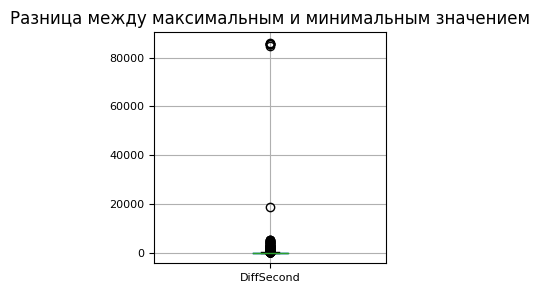

In [869]:
data_wire_time.boxplot('DiffSecond', figsize=(3, 3), fontsize=8)
plt.title('Разница между максимальным и минимальным значением')
plt.show()

__Примечание__: на графике видны аномальные всплески в районе 80000 - это и есть переходы на другие сутки

Преобразуем данные таким образом, чтобы выводилось не время, а количество секунд, которое прошло с момента подачи материала

In [870]:
# объеденим данные с "данными об электродах"
data_wire_time = data_wire_time.merge(data_arc[['BeginHeatSeconds']], how='inner', left_index=True, right_index=True)
# пропуски заполним отрицательным значением
data_wire_time = data_wire_time.fillna(-1)

# обработаем только те колонки, у которых тип time
for col in cols:
    if col.find('Wire') >= 0:
        data_wire_time[f'{col}Time'] = data_wire_time[[f'{col}Time', 'BeginHeatSeconds']].apply(to_second, axis=1)

In [871]:
# удалим временные колонки
data_wire_time.drop(columns=cols, inplace=True)
data_wire_time.drop(columns=['BeginHeatSeconds', 'MinSecond', 'MaxSecond', 'DiffSecond'], inplace=True)

# проверим распределение
data_wire_time.describe()

,Wire 1Time,Wire 2Time,Wire 3Time,Wire 4Time,Wire 5Time,Wire 6Time,Wire 7Time,Wire 8Time,Wire 9Time
count,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000
mean,2432.554221,892.056169,89.486688,7.373701,1.091883,84.347078,23.876299,36.397078,90.657143
std,11463.112347,6655.094272,2008.924301,131.706005,116.094801,2201.477986,491.365387,1559.834406,2686.139403
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,508.750000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,748.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,1010.250000,754.250000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
max,86396.000000,86398.000000,85915.000000,2507.000000,6442.000000,86372.000000,20419.000000,86259.000000,86323.000000
